In [1]:
import pandas as pd

df = pd.read_csv('Processed_Specificities_Data.csv')

In [2]:
df = df[df['Target Name'] != 'P2X purinoceptor 4']
df = df.dropna()

df = pd.get_dummies(df, columns=['Target Name'])

print(df.head())

   Molecular Weight  AlogP                                             Smiles  \
0            497.60   4.39  COc1ccc(CC(=O)N2CCN(/C(=N/C#N)Nc3ccccc3C)CC2c2...   
1            438.81   4.65  O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(ncn2-c2ccccn2...   
2            473.80   5.76  O=C(c1cccc(C(F)(F)F)c1Cl)N1CCc2c(nc(C(F)(F)F)n...   
3            438.81   4.84  C[C@H]1c2ncn(-c3ccc(F)cn3)c2CCN1C(=O)c1cccc(C(...   
4            437.82   5.44  C[C@H]1c2ncn(-c3ccc(F)cc3)c2CCN1C(=O)c1cccc(C(...   

     pValue  Target Name_Adenosine A2a receptor  \
0  6.853872                               False   
1  7.183759                               False   
2  6.897909                               False   
3  5.000000                               False   
4  5.690008                               False   

   Target Name_P2X purinoceptor 7  \
0                            True   
1                            True   
2                            True   
3                            True   
4                    

In [3]:
print(df.shape)

(4727, 7)


In [4]:
df.reset_index(drop=True, inplace=True)

In [5]:
print("Counts for each target:")
print("P2X purinoceptor 7:", df['Target Name_P2X purinoceptor 7'].sum())
print("Adenosine A2a receptor:", df['Target Name_Adenosine A2a receptor'].sum())
print("Voltage-gated L-type calcium channel alpha-1C subunit:", df['Target Name_Voltage-gated L-type calcium channel alpha-1C subunit'].sum())

Counts for each target:
P2X purinoceptor 7: 1103
Adenosine A2a receptor: 2503
Voltage-gated L-type calcium channel alpha-1C subunit: 1121


In [6]:
!pip install selfies

In [7]:
import pandas as pd
import numpy as np
import selfies as sf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
import tensorflow as tf

In [8]:
def smiles_to_selfies(smiles):
    return sf.encoder(smiles)

df['Selfies'] = df['Smiles'].apply(smiles_to_selfies)

In [9]:
print(df['Selfies'])

0       [C][O][C][=C][C][=C][Branch2][Ring2][=Branch2]...
1       [O][=C][Branch2][Ring1][Ring2][C][=C][C][=C][C...
2       [O][=C][Branch2][Ring1][Ring2][C][=C][C][=C][C...
3       [C][C@H1][C][N][=C][N][Branch1][N][C][=C][C][=...
4       [C][C@H1][C][N][=C][N][Branch1][N][C][=C][C][=...
                              ...                        
4722    [C][C][C][Branch1][=Branch1][C][=Branch1][C][=...
4723    [C][C][Branch1][C][N][C][Branch1][C][O][C][=C]...
4724    [C][C][C][C][O][C@@H1][C][C@H1][C@@H1][C][C][C...
4725            [N][C][C][C][C][C][C][=Branch1][C][=O][O]
4726    [C][C][Branch1][#Branch2][C][N+1][Branch1][C][...
Name: Selfies, Length: 4727, dtype: object


In [10]:
selfies_list = df['Selfies'].tolist()
dot_count = sum(1 for selfie in selfies_list if '.' in selfie)

print(f"Number of SELFIES containing the '.' symbol: {dot_count}")

Number of SELFIES containing the '.' symbol: 37


In [11]:
df = df[~df['Selfies'].str.contains('\.')]
df.reset_index(drop=True, inplace=True)

print(f"Number of rows after removing entries with '.': {df.shape[0]}")

Number of rows after removing entries with '.': 4690


In [12]:
print(df['Selfies'])

0       [C][O][C][=C][C][=C][Branch2][Ring2][=Branch2]...
1       [O][=C][Branch2][Ring1][Ring2][C][=C][C][=C][C...
2       [O][=C][Branch2][Ring1][Ring2][C][=C][C][=C][C...
3       [C][C@H1][C][N][=C][N][Branch1][N][C][=C][C][=...
4       [C][C@H1][C][N][=C][N][Branch1][N][C][=C][C][=...
                              ...                        
4685    [C][C][C][Branch1][=Branch1][C][=Branch1][C][=...
4686    [C][C][Branch1][C][N][C][Branch1][C][O][C][=C]...
4687    [C][C][C][C][O][C@@H1][C][C@H1][C@@H1][C][C][C...
4688            [N][C][C][C][C][C][C][=Branch1][C][=O][O]
4689    [C][C][Branch1][#Branch2][C][N+1][Branch1][C][...
Name: Selfies, Length: 4690, dtype: object


In [13]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def get_selfies_alphabet(selfies_list):
    alphabet = set()
    for s in selfies_list:
        alphabet.update(sf.split_selfies(s))
    alphabet = sorted(list(alphabet))  # Sorting to ensure consistent ordering
    return alphabet

def selfies_to_one_hot(selfies_list, alphabet):
    max_length = max(sf.len_selfies(s) for s in selfies_list)
    alphabet_index = {symbol: idx for idx, symbol in enumerate(alphabet)}
    one_hot_encoded = torch.zeros((len(selfies_list), max_length, len(alphabet)), dtype=torch.float32)

    for i, selfie in enumerate(selfies_list):
        symbols = sf.split_selfies(selfie)
        for j, symbol in enumerate(symbols):
            symbol_idx = alphabet_index[symbol]
            one_hot_encoded[i, j, symbol_idx] = 1
    return one_hot_encoded

selfies_list = df['Selfies'].tolist()
alphabet = get_selfies_alphabet(selfies_list)
encoded_selfies = selfies_to_one_hot(selfies_list, alphabet)

In [14]:
print(len(alphabet))

56


In [15]:
print(encoded_selfies.shape)

torch.Size([4690, 113, 56])


In [16]:
df_p2rx7 = df[df['Target Name_P2X purinoceptor 7'] == True]
df_aa2a = df[df['Target Name_Adenosine A2a receptor'] == True]
df_cacna1c = df[df['Target Name_Voltage-gated L-type calcium channel alpha-1C subunit'] == True]

In [18]:
def prepare_inputs(encoded_selfies, df):
    # Flattening the SELFIES encoding for concatenation
    selfies_flattened = encoded_selfies.view(encoded_selfies.size(0), -1)  # Flattening each SELFIES encoding
    targets = torch.tensor(df['pValue'].values, dtype=torch.float32)
    return selfies_flattened, targets

# Extracting and preparing features and targets
features_p2rx7, targets_p2rx7 = prepare_inputs(encoded_selfies[df_p2rx7.index], df_p2rx7)
features_aa2a, targets_aa2a = prepare_inputs(encoded_selfies[df_aa2a.index], df_aa2a)
features_cacna1c, targets_cacna1c = prepare_inputs(encoded_selfies[df_cacna1c.index], df_cacna1c)

In [19]:
!pip install rdkit-pypi

In [21]:
from sklearn.model_selection import train_test_split

def split_data(features, targets):
    features_train, features_val, targets_train, targets_val = train_test_split(
        features, targets, test_size=0.2, random_state=42)
    return features_train, features_val, targets_train, targets_val

features_p2rx7_train, features_p2rx7_val, targets_p2rx7_train, targets_p2rx7_val = split_data(features_p2rx7, targets_p2rx7)
features_aa2a_train, features_aa2a_val, targets_aa2a_train, targets_aa2a_val = split_data(features_aa2a, targets_aa2a)
features_cacna1c_train, features_cacna1c_val, targets_cacna1c_train, targets_cacna1c_val = split_data(features_cacna1c, targets_cacna1c)

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# Initializing MLP Regressor
mlp_p2rx7 = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=42)
mlp_aa2a = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=42)
mlp_cacna1c = MLPRegressor(hidden_layer_sizes=(500,), max_iter=1000, random_state=42)

# Training MLP Regressor for each target
mlp_p2rx7.fit(features_p2rx7_train, targets_p2rx7_train)
y_pred_p2rx7_mlp = mlp_p2rx7.predict(features_p2rx7_val)
mse_p2rx7_mlp = mean_squared_error(targets_p2rx7_val, y_pred_p2rx7_mlp)

mlp_aa2a.fit(features_aa2a_train, targets_aa2a_train)
y_pred_aa2a_mlp = mlp_aa2a.predict(features_aa2a_val)
mse_aa2a_mlp = mean_squared_error(targets_aa2a_val, y_pred_aa2a_mlp)

mlp_cacna1c.fit(features_cacna1c_train, targets_cacna1c_train)
y_pred_cacna1c_mlp = mlp_cacna1c.predict(features_cacna1c_val)
mse_cacna1c_mlp = mean_squared_error(targets_cacna1c_val, y_pred_cacna1c_mlp)

# Printing MSE for MLP Regressor for each target
print("Mean Squared Error for p2rx7 (MLP Regressor):", mse_p2rx7_mlp)
print("Mean Squared Error for aa2a (MLP Regressor):", mse_aa2a_mlp)
print("Mean Squared Error for cacna1c (MLP Regressor):", mse_cacna1c_mlp)

Mean Squared Error for p2rx7 (MLP Regressor): 1.7587276093586592
Mean Squared Error for aa2a (MLP Regressor): 1.2656520764209773
Mean Squared Error for cacna1c (MLP Regressor): 0.6871710577066729


In [24]:
from sklearn.ensemble import RandomForestRegressor

# Initializing and training Random Forest Regressor for each target
rf_p2rx7 = RandomForestRegressor(n_estimators=200, random_state=42)
rf_p2rx7.fit(features_p2rx7_train, targets_p2rx7_train)
y_pred_p2rx7_rf = rf_p2rx7.predict(features_p2rx7_val)
mse_p2rx7_rf = mean_squared_error(targets_p2rx7_val, y_pred_p2rx7_rf)

rf_aa2a = RandomForestRegressor(n_estimators=400, random_state=42)
rf_aa2a.fit(features_aa2a_train, targets_aa2a_train)
y_pred_aa2a_rf = rf_aa2a.predict(features_aa2a_val)
mse_aa2a_rf = mean_squared_error(targets_aa2a_val, y_pred_aa2a_rf)

rf_cacna1c = RandomForestRegressor(n_estimators=200, random_state=42)
rf_cacna1c.fit(features_cacna1c_train, targets_cacna1c_train)
y_pred_cacna1c_rf = rf_cacna1c.predict(features_cacna1c_val)
mse_cacna1c_rf = mean_squared_error(targets_cacna1c_val, y_pred_cacna1c_rf)

# Printing MSE for Random Forest Regressor for each target
print("MSE for p2rx7 (Random Forest):", mse_p2rx7_rf)
print("MSE for aa2a (Random Forest):", mse_aa2a_rf)
print("MSE for cacna1c (Random Forest):", mse_cacna1c_rf)

MSE for p2rx7 (Random Forest): 1.068709210353368
MSE for aa2a (Random Forest): 0.6312098781081135
MSE for cacna1c (Random Forest): 0.36841849220731954


In [25]:
from xgboost import XGBRegressor

# Initializing and training XGBRegressor for each target
xgb_p2rx7 = XGBRegressor(n_estimators=400, learning_rate=0.01, random_state=42)
xgb_p2rx7.fit(features_p2rx7_train, targets_p2rx7_train)
y_pred_p2rx7_xgb = xgb_p2rx7.predict(features_p2rx7_val)
mse_p2rx7_xgb = mean_squared_error(targets_p2rx7_val, y_pred_p2rx7_xgb)

xgb_aa2a = XGBRegressor(n_estimators=1200, learning_rate=0.01, random_state=42)
xgb_aa2a.fit(features_aa2a_train, targets_aa2a_train)
y_pred_aa2a_xgb = xgb_aa2a.predict(features_aa2a_val)
mse_aa2a_xgb = mean_squared_error(targets_aa2a_val, y_pred_aa2a_xgb)

xgb_cacna1c = XGBRegressor(n_estimators=300, learning_rate=0.01, random_state=42)
xgb_cacna1c.fit(features_cacna1c_train, targets_cacna1c_train)
y_pred_cacna1c_xgb = xgb_cacna1c.predict(features_cacna1c_val)
mse_cacna1c_xgb = mean_squared_error(targets_cacna1c_val, y_pred_cacna1c_xgb)

# Printing MSE for XGBRegressor for each target
print("MSE for p2rx7 (XGBoost):", mse_p2rx7_xgb)
print("MSE for aa2a (XGBoost):", mse_aa2a_xgb)
print("MSE for cacna1c (XGBoost):", mse_cacna1c_xgb)

MSE for p2rx7 (XGBoost): 1.0514318
MSE for aa2a (XGBoost): 0.71948457
MSE for cacna1c (XGBoost): 0.37437055


In [26]:
from sklearn.svm import SVR

# Initialize and train SVR for each target
svm_p2rx7 = SVR(kernel='rbf')
svm_p2rx7.fit(features_p2rx7_train, targets_p2rx7_train)
y_pred_p2rx7_svm = svm_p2rx7.predict(features_p2rx7_val)
mse_p2rx7_svm = mean_squared_error(targets_p2rx7_val, y_pred_p2rx7_svm)

svm_aa2a = SVR(kernel='rbf')
svm_aa2a.fit(features_aa2a_train, targets_aa2a_train)
y_pred_aa2a_svm = svm_aa2a.predict(features_aa2a_val)
mse_aa2a_svm = mean_squared_error(targets_aa2a_val, y_pred_aa2a_svm)

svm_cacna1c = SVR(kernel='rbf')
svm_cacna1c.fit(features_cacna1c_train, targets_cacna1c_train)
y_pred_cacna1c_svm = svm_cacna1c.predict(features_cacna1c_val)
mse_cacna1c_svm = mean_squared_error(targets_cacna1c_val, y_pred_cacna1c_svm)

# Printing MSE for SVR for each target
print("MSE for p2rx7 (SVM):", mse_p2rx7_svm)
print("MSE for aa2a (SVM):", mse_aa2a_svm)
print("MSE for cacna1c (SVM):", mse_cacna1c_svm)

MSE for p2rx7 (SVM): 1.108987468889943
MSE for aa2a (SVM): 0.6886674418036633
MSE for cacna1c (SVM): 0.32660789754160396


In [27]:
from torch.utils.data import TensorDataset, DataLoader

# modifying prepare_inputs without targets
def prepare_inputs(df, encoded_selfies):
    # Assuming encoded_selfies is already a tensor matching the index of df
    selfies_flattened = encoded_selfies.view(len(df), -1)  # Flattening each SELFIES encoding
    return selfies_flattened

In [28]:
# Extracting and preparing features for the entire dataset
features = prepare_inputs(df, encoded_selfies)

In [29]:
dataset = TensorDataset(features)  # Assuming features are the only input
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [30]:
print(features.shape)

torch.Size([4690, 6328])


In [59]:
import torch
from torch import nn

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, middle_dim1, middle_dim2, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, middle_dim1),
            nn.ReLU(),
            nn.Linear(middle_dim1, middle_dim2),
            nn.ReLU(),
            nn.Linear(middle_dim2, latent_dim * 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, middle_dim2),
            nn.ReLU(),
            nn.Linear(middle_dim2, middle_dim1),
            nn.ReLU(),
            nn.Linear(middle_dim1, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder(x)
        mu, log_var = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decoder(z)
        return x_recon, mu, log_var

input_dim = encoded_selfies.size(1) * encoded_selfies.size(2)
hidden_dim = 512
middle_dim1 = 256
middle_dim2 = 128
latent_dim = 10

vae = VAE(input_dim, hidden_dim, middle_dim1, middle_dim2, latent_dim).to('cpu')

In [60]:
def loss_function(recon_x, x, mu, log_var, rf_model_p2rx7, rf_model_aa2a, rf_model_cacna1c):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    predicted_properties = recon_x.detach().numpy()
    pvalues_p2rx7 = rf_model_p2rx7.predict(predicted_properties)
    pvalues_aa2a = rf_model_aa2a.predict(predicted_properties)
    pvalues_cacna1c = rf_model_cacna1c.predict(predicted_properties)

    # Custom loss components to steer generation
    p2rx7_loss = -torch.tensor(pvalues_p2rx7).mean()  # We want to maximize this
    aa2a_loss = torch.tensor(pvalues_aa2a).mean()     # We want to minimize this
    cacna1c_loss = torch.tensor(pvalues_cacna1c).mean()  # We want to minimize this

    return BCE + KLD + 3000*(p2rx7_loss) + 2000*(aa2a_loss) + 1500*(cacna1c_loss)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)

num_epochs = 40
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch in data_loader:
        batch = batch[0].to('cpu')
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(batch)
        loss = loss_function(recon_batch, batch, mu, log_var, rf_p2rx7, rf_aa2a, rf_cacna1c)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(data_loader.dataset)}')

Epoch 1, Loss: 165.0648185531853
Epoch 2, Loss: 93.71423999908933
Epoch 3, Loss: 91.2119420208665
Epoch 4, Loss: 87.9604132252454
Epoch 5, Loss: 87.46194759155863
Epoch 6, Loss: 86.63636425780149
Epoch 7, Loss: 87.5424417400073
Epoch 8, Loss: 87.3180754176209
Epoch 9, Loss: 88.09582132320612
Epoch 10, Loss: 87.4831589887809
Epoch 11, Loss: 87.65701672266495
Epoch 12, Loss: 86.53797838997438
Epoch 13, Loss: 87.85935447800834
Epoch 14, Loss: 86.42556851576123
Epoch 15, Loss: 87.870183129688
Epoch 16, Loss: 86.22137741122486
Epoch 17, Loss: 85.27554038049071
Epoch 18, Loss: 85.48588944002604
Epoch 19, Loss: 84.67154633173337
Epoch 20, Loss: 84.00661681330642
Epoch 21, Loss: 85.14616390129692
Epoch 22, Loss: 84.83006885170573
Epoch 23, Loss: 84.78542881821016
Epoch 24, Loss: 84.75699201152334
Epoch 25, Loss: 83.61239317988628
Epoch 26, Loss: 82.72196821438297
Epoch 27, Loss: 85.00980330395757
Epoch 28, Loss: 85.16603742121771
Epoch 29, Loss: 85.06291548237462
Epoch 30, Loss: 83.79059267383

In [74]:
def generate_selfies(vae, num_samples, latent_dim):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to('cpu')
        generated = vae.decoder(z).cpu().numpy()
    return generated

num_samples = 10
generated_selfies = generate_selfies(vae, num_samples, latent_dim)

# Converting generated vectors back to SELFIES
def decode_selfies(generated, alphabet):
    decoded_selfies = []
    for gen in generated:
        selfies_str = ''
        for i in range(0, len(gen), len(alphabet)):
            one_hot = gen[i:i+len(alphabet)]
            symbol = alphabet[one_hot.argmax()]
            selfies_str += symbol
        decoded_selfies.append(selfies_str)
    return decoded_selfies

decoded_selfies = decode_selfies(generated_selfies, alphabet)
print(decoded_selfies)

['[C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][C][C][Ring1][C][Ring1][Ring1][O][Ring2][Ring1][Ring1][Ring1][C][Ring1][#C][Ring2][Ring2][Branch1][C][C][Ring2][C][C][C][C][Ring2][C][Ring2][C][C][C][=C][Ring2][Ring2][#Branch1][O][Ring2][Ring2][N][=O][Ring2][Ring2][Branch1][Ring2][Ring1][#C][C][Branch1][C][O][C][Ring2][Ring1][Ring2][C][C][C][=O][O][Branch1][C][C][C][P][O]', '[C][C][C][C][C][C][C][C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][#Branch2][O][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][#Branch2][Ring1][Branch2][O][C][Ring2][Ring1][C][C][C][C][Ring1][C][Ring2][C][C][Ring2][C][C][C][Ring1][C][C][Branch1][C][C][C][Ring2][C][Ring1][C][=C][Ring2][C][C][C][Ring2][Ring2][N][=O][Ring2][Ring2][Ring1][Ring2][Ring2][#C][C][Branch1][C][O][C][Ring2][#C][Ring2][C][C][C][Ring2][#Branch1][Branch1][C][C][C]

In [75]:
print(len(decoded_selfies))

10


In [76]:
print(generated_selfies.shape)

(10, 6328)


In [77]:
# Predicting p-values using the trained Random Forest models
p2rx7_pvalues = rf_p2rx7.predict(generated_selfies)
aa2a_pvalues = rf_aa2a.predict(generated_selfies)
cacna1c_pvalues = rf_cacna1c.predict(generated_selfies)

for i in range(num_samples):
    print(f"Generated SELFIES: {decoded_selfies[i]}")
    print(f"P2RX7 p-value: {p2rx7_pvalues[i]}")
    print(f"AA2A p-value: {aa2a_pvalues[i]}")
    print(f"CACNA1C p-value: {cacna1c_pvalues[i]}")
    print("---")

Generated SELFIES: [C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][C][C][Ring1][C][Ring1][Ring1][O][Ring2][Ring1][Ring1][Ring1][C][Ring1][#C][Ring2][Ring2][Branch1][C][C][Ring2][C][C][C][C][Ring2][C][Ring2][C][C][C][=C][Ring2][Ring2][#Branch1][O][Ring2][Ring2][N][=O][Ring2][Ring2][Branch1][Ring2][Ring1][#C][C][Branch1][C][O][C][Ring2][Ring1][Ring2][C][C][C][=O][O][Branch1][C][C][C][P][O]
P2RX7 p-value: 6.800712422456061
AA2A p-value: 5.445437143859997
CACNA1C p-value: 4.985686359405517
---
Generated SELFIES: [C][C][C][C][C][C][C][C][C][=C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][C][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][#Branch2][O][Ring1][Ring1][Ring1][Ring1][Ring1][Ring1][#Branch2][Ring1][Branch2][O][C][Ring2][Ring1][C][C][C][C][Ring1][C][Ring2][C][C][Ring2][C][C][C][Ring1][C][C][Branch1][C][C][C][Ring2][C][Ring1][C][=C][Ring2][C][C][C][Ring2

In [78]:
def selfies_to_smiles(decoded_selfies):
    smiles_list = []
    for selfies in decoded_selfies:
        try:
            smiles = sf.decoder(selfies)
            smiles_list.append(smiles)
        except sf.DecoderError as e:
            print(f"Error decoding SELFIES to SMILES: {e}")
            smiles_list.append(None)
    return smiles_list

smiles_list = selfies_to_smiles(decoded_selfies)

In [79]:
for i in smiles_list:
    print(i)

CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1CCCCCCCCCCCCCCC2=C=C2O1
CCCCCCCCC=CCCCCCCCCCCCCCCCCCCCC=1CC=1
CCCNC=C=CC(=O)NC=CNC(C)CCCC=CC=CCCCCC1CC2CCCCCCCCCCCCCCC=CC21OOO
CC=NCCCCCC=CCCCCCCCCCCCCCCCCCCCC=1C=C=1
CCCCCCCCCCCCCCCCCCCCCCCCCCCCC1C=2CC=21
CCCCCCCCCCCCCC=CCCCCCCCCCCCCCCCCCCCCCCCC=1CC=1
CC=NCCCCCC=CCCCCCCCCCCCCCCCCCCCC=1CC=1
CC=NC(N)CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC1C2=C=C21
CCCCCCCCCCCCCCCCCCCCCCCC=C1CC1CC#C
CCC=CC=C(CC(=O)NC=CN/C(=N/C#N)NC1=CC=CC2=C1CCCCCCCCCCCC=C)C=NC2C=O


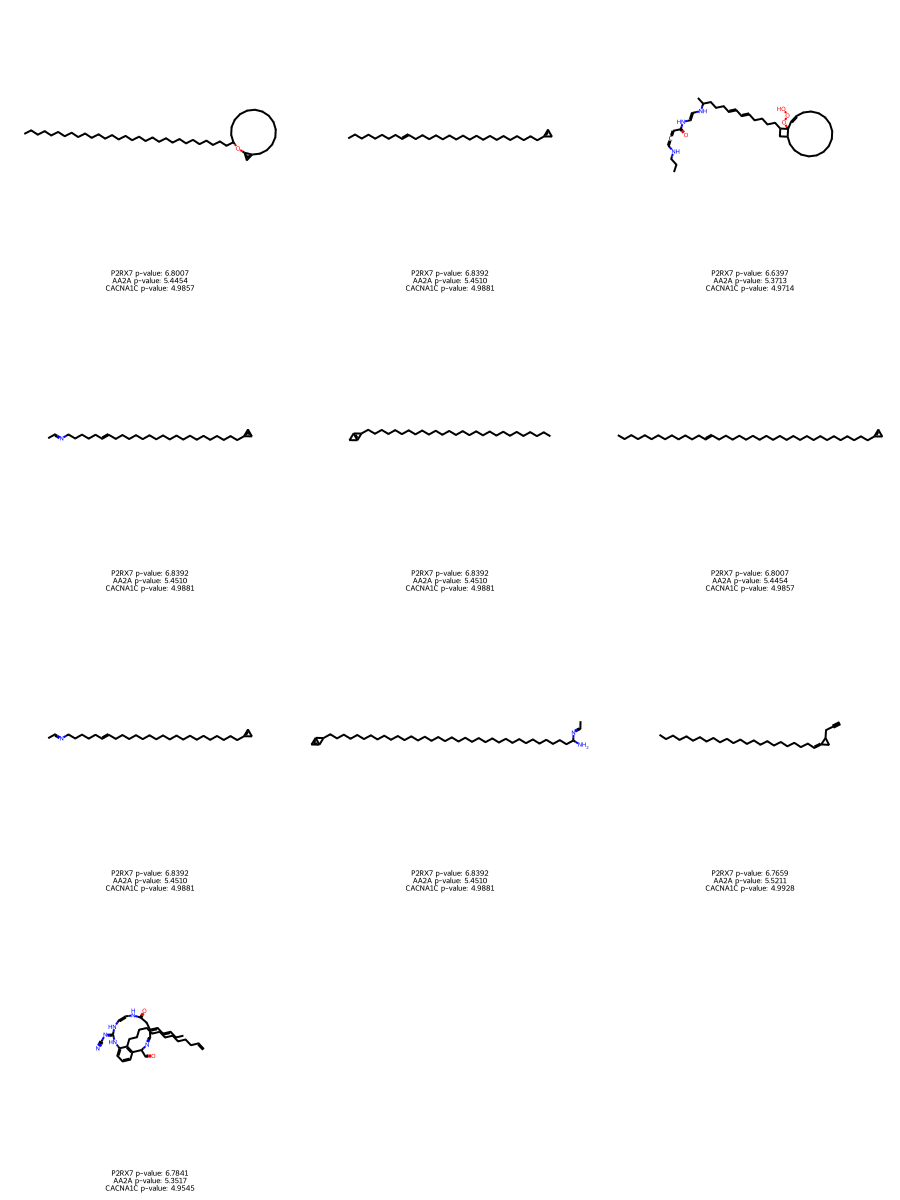

In [80]:
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

def visualize_smiles(smiles_list):
    molecules = []
    legends = []
    for i, smiles in enumerate(smiles_list):
        if smiles is not None:
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                molecules.append(mol)
                legend = (f"P2RX7 p-value: {p2rx7_pvalues[i]:.4f}\n"
                          f"AA2A p-value: {aa2a_pvalues[i]:.4f}\n"
                          f"CACNA1C p-value: {cacna1c_pvalues[i]:.4f}")
                legends.append(legend)
            else:
                print("Failed to create molecule from SMILES:", smiles)
        else:
            print("Invalid SMILES provided")

    if molecules:
        img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300), legends=legends)
        return img
    else:
        print("No valid molecules to display.")

img = visualize_smiles(smiles_list)
display(img)